# Data Augmentation

## 학습 목표



*   Tensorflow built-in Augmentation API 실습
*   SOTA Augmentation 실습
- 위의 결과를 활용하여 ResNet 50-Layer 학습



In [ ]:
import shutil
import glob
import os
import sys
import pickle
import random

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import tensorflow as tf

In [ ]:
random_seed = 1234

random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
%matplotlib inline

# plt.style.use('default')
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False
mpl.rcParams.update({'figure.autolayout': True})

warnings.filterwarnings('ignore')

In [ ]:
# this code is for not printing warning error info
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import tensorflow_datasets as tfds
from tensorflow import keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization

In [ ]:
path_drive = '/content/drive/MyDrive/Colab Notebooks/GoingDeeper/4'

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
path = path_drive + '/yo'

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=path)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image'

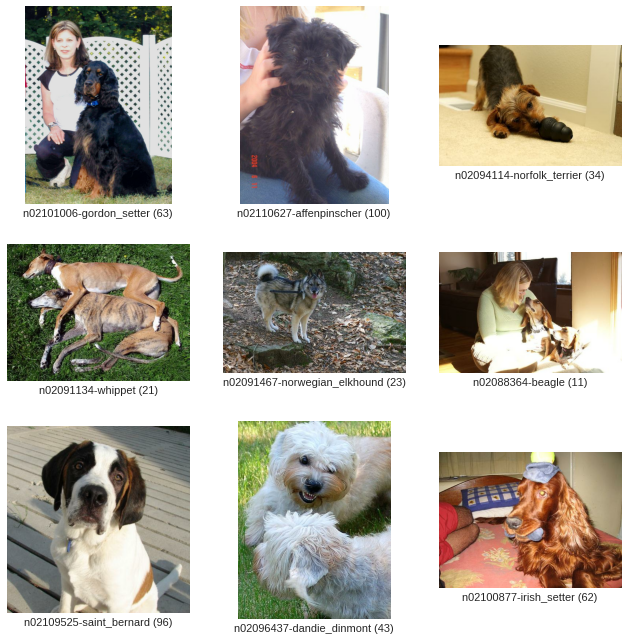

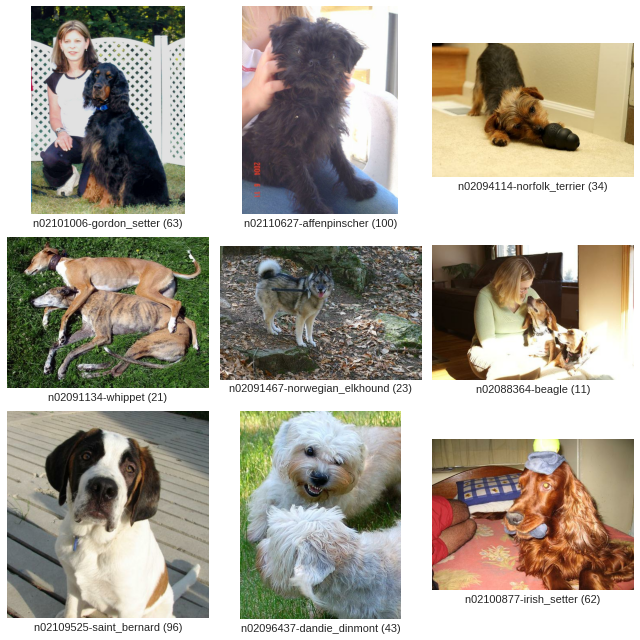

In [ ]:
tfds.show_examples(ds_train, ds_info)

# 출처

 - _Transfer Learning 시에 주의할 점_  

  - https://inhovation97.tistory.com/31
  - https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/



# 실습

In [ ]:
model = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    )

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
len(model.layers)

176

In [ ]:
model.layers[175]

In [ ]:
model.input_shape

(None, 224, 224, 3)

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
num_classes = ds_info.features["label"].num_classes

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    if not is_test:
      ds = ds.repeat(4)
      ds = ds.shuffle(batch_size*20)
    
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train

<_OptionsDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir=path
)

ds_train_ = apply_normalize_on_dataset(ds_train, batch_size=512)
ds_val_ = apply_normalize_on_dataset(ds_val, batch_size=512)
print(len(ds_train), len(ds_val), len(ds_test))
ds_train_

10800 1200 8580


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

# 실패한 시도
___pretained model에서 뽑은 feature map으로 FC만 학습하려고 했지만 hyper parameter 조정이 까다롭고 성능 개선이 어려워 일단 보류___

In [ ]:
pred_train = model.predict(ds_train_, verbose=1)
pred_val = model.predict(ds_val_)

1350/1350 [==============================] - 102s 66ms/step


In [ ]:
np.save(open('pred_train.npy', 'wb'), pred_train)
np.save(open('pred_val.npy', 'wb'), pred_val)

In [ ]:
pred_train

array([[0.0000000e+00, 0.0000000e+00, 6.1570870e-04, ..., 2.0406106e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.6773633e-03, ..., 1.8598537e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0988555e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.8649690e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 8.8988300e-03, ..., 2.0929782e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.0093333e-03, ..., 2.0536098e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
pred_train.shape

(43200, 2048)

In [ ]:
_model = Sequential()
# _model.add(Dense(1000, kernel_initializer='he_normal', activation='relu'))
# _model.add(Dropout(0.5))
# _model.add(Dense(200, kernel_initializer='he_normal', activation='relu'))
# _model.add(Dropout(0.5))
_model.add(Dense(120, activation='softmax'))

In [ ]:
_model.compile(optimizer=keras.optimizers.SGD(lr=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
_model.fit(x=pred_train, y=y, epochs=100)

Epoch 1/100
1350/1350 [==============================] - 3s 2ms/step - loss: 289.9672 - acc: 0.0074
Epoch 2/100
1350/1350 [==============================] - 3s 2ms/step - loss: 294.4583 - acc: 0.0085
Epoch 3/100
1350/1350 [==============================] - 3s 2ms/step - loss: 297.0259 - acc: 0.0080
Epoch 4/100
1350/1350 [==============================] - 3s 2ms/step - loss: 295.2531 - acc: 0.0084
Epoch 5/100
1350/1350 [==============================] - 3s 2ms/step - loss: 286.4833 - acc: 0.0079
Epoch 6/100
1350/1350 [==============================] - 3s 2ms/step - loss: 291.0821 - acc: 0.0086
Epoch 7/100
1350/1350 [==============================] - 3s 3ms/step - loss: 287.5802 - acc: 0.0084
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 284.5155 - acc: 0.0082
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 285.2404 - acc: 0.0097
Epoch 10/100
1350/1350 [==============================] - 3s 2ms/step - loss: 276.6255 - acc: 0.0087

KeyboardInterrupt: ignored

# 다른 방법

In [ ]:
model = keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    )

In [ ]:
from tensorflow.keras import Model

out = Dense(120, activation='softmax')(model.output)

model = Model(model.input, out)

In [ ]:
model.summary()

In [ ]:
len(model.layers)

177

In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train_, epochs=2, verbose=1)

Epoch 1/2
85/85 [==============================] - 174s 2s/step - loss: 5.0392 - accuracy: 0.0083
Epoch 2/2
85/85 [==============================] - 151s 2s/step - loss: 4.8726 - accuracy: 0.0081


In [ ]:
ds_train_ = apply_normalize_on_dataset(ds_train, batch_size=512)
ds_val_ = apply_normalize_on_dataset(ds_val, batch_size=512)

In [ ]:
model.optimizer.lr

<tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.1>

In [ ]:
model.layers[-34]

In [ ]:
for layer in model.layers[-34:]:
    layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
file_path = path_drive + '/checkpoint'
check_point = tf.keras.callbacks.ModelCheckpoint(file_path, verbose=1, save_best_only=True)
check_point

In [ ]:
history = model.fit(ds_train_, epochs=1, verbose=1, validation_data=ds_val_, callbacks=[check_point])

85/85 [==============================] - ETA: 0s - loss: 4.2451 - accuracy: 0.1395
Epoch 1: val_loss improved from inf to 4.76484, saving model to /content/drive/MyDrive/Colab Notebooks/GoingDeeper/4/checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/GoingDeeper/4/checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/GoingDeeper/4/checkpoint/assets


85/85 [==============================] - 225s 3s/step - loss: 4.2451 - accuracy: 0.1395 - val_loss: 4.7648 - val_accuracy: 0.0233


In [ ]:
model.load_weights(file_path)
model.summary()

In [ ]:
ds_train_ = apply_normalize_on_dataset(ds_train, batch_size=2048)
ds_val_ = apply_normalize_on_dataset(ds_val, batch_size=2048)

In [ ]:
model.layers[-58]

In [ ]:
for layer in model.layers[:]:
    layer.trainable = True

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train_, epochs=5, verbose=1)

Epoch 1/5


In [ ]:
yo_ds_train_ = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=512)
yo_ds_val_ = apply_normalize_on_dataset(ds_val, with_aug=True, batch_size=512)
yo_ds_test_ = apply_normalize_on_dataset(ds_test, with_aug=True, batch_size=512)

yo_ds_train_

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [ ]:
model.fit(yo_ds_train_, epochs=3, verbose=1)

NameError: ignored